In [1]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
from matplotlib import pyplot as plt

from scripts.models import MLP, LinearFlow, LinearFlowWithBias, ConcatMLP, Autoencoder, SharedWeightAutoencoder, AntiSymmetricLinearFlow, KoopmanAE
from scripts.losses import CNF_batch_loss, CNF_reverse_kl_batch_loss
from scripts.distributions import sample_multimodal_gaussian, multimodal_gaussian_pdf, multimodal_gaussian_logpdf, get_hypersphere_modes, define_distributions
from scripts.training import train_CNF, train_CNF_analytic, train_KoopmanAE
from scripts.utils.distribution_statistics import stable_rank_svd

In [2]:
model_dict = {
    'linear': LinearFlow,
    'linear_with_bias': LinearFlowWithBias,
    'linear_antisym': AntiSymmetricLinearFlow,
    'mlp': MLP,
    'autoencoder': Autoencoder,
    'shared_weight_autoencoder': SharedWeightAutoencoder,
    'concat': ConcatMLP
}

calc_rank_dict = {
    'linear': lambda weight_list: stable_rank_svd(jnp.array(weight_list[0])),
    'linear_with_bias': lambda weight_list: stable_rank_svd(jnp.array(weight_list[0])),
    'linear_antisym': lambda weight_list: jnp.array([stable_rank_svd(weight_list[0]), stable_rank_svd((weight_list[0] - weight_list[0].T)/2)]),
    'mlp': lambda weight_list: jnp.array([stable_rank_svd(weight_list[0]), stable_rank_svd(weight_list[2])]),
    'autoencoder': lambda weight_list: jnp.array([stable_rank_svd(weight_list[0]), stable_rank_svd(weight_list[1])]),
    'shared_weight_autoencoder': lambda weight_list: stable_rank_svd(jnp.array(weight_list[0])),
    'concat':  lambda weight_list: jnp.array([stable_rank_svd(weight_list[0]), stable_rank_svd(weight_list[5])])
}

"""
model args:
antisym=(dim, key, init_var)
linear=(dim, key, init_var, init_weight)
concat=(datasize, width, depth, key, init_std)
mlp=(dim, width, depth, hidden_act, final_act, init_std, key)
"""

'\nmodel args:\nantisym=(dim, key, init_var)\nlinear=(dim, key, init_var, init_weight)\nconcat=(datasize, width, depth, key, init_std)\nmlp=(dim, width, depth, hidden_act, final_act, init_std, key)\n'

### Train with empirical loss

In [3]:
model_key, train_key, mode_key1, mode_key2 = jax.random.split(jax.random.PRNGKey(1009), 4)

# Define model
dim = 10
model_type = 'linear'
model_args = (model_key, dim, 0.01)
# model_args = (dim, dim, 3, jax.nn.tanh, jax.nn.identity, 0.01, model_key)
model = model_dict[model_type](*model_args)
model_save_name = 'Linear_10D_10radius_5modes_orthogonal_001init_10000batch_1009key'
save_model = True

# Define training params
lr = 1e-3
weight_decay = 1e-5
optimizer = optax.sgd(lr)
training_iterations = 10000
batch_size = 10000

# Define distributions
initial_radius = 10
target_radius = 10
num_initial_modes = 5
num_target_modes = 5
mode_arrangement = 'orthogonal'
eps_deg = 5
unimodal_init = False
initial_modes, target_modes, initial_sampler, target_sampler, initial_pdf, target_pdf = define_distributions(dim, initial_radius, target_radius, num_initial_modes, num_target_modes, mode_arrangement, num_samples=batch_size,  key=jax.random.PRNGKey(0), unimodal_init=unimodal_init, eps_deg=eps_deg)

# Loss fn
ts_forwards = [0, 1, 0.01]
loss_fn = lambda model, zs, key: CNF_reverse_kl_batch_loss(model, zs, ts_forwards, target_pdf, key, approx=True)

# print(f'Initial modes: {initial_modes}')
# print(f'Target modes: {target_modes}')

# Train model
save_weights_and_grads = True
save_biases = False
trained_model, losses, weights, biases, weight_ranks, gradients = train_CNF(model, initial_sampler, loss_fn, optimizer, train_key, 
                                                    training_iterations, calc_rank_fn=calc_rank_dict[model_type], 
                                                    save_weights_and_grads=save_weights_and_grads, save_biases=save_biases)

# Save trained model
if save_model:
    to_save = {
        'model': trained_model,
        'losses': losses,
        'weights': weights,
        'biases': biases,
        'weight_ranks': weight_ranks,
        'gradients': gradients}
    eqx.tree_serialise_leaves(f'{model_save_name}.eqx', to_save)

Loss: 17.56079: 100%|██████████| 10000/10000 [45:57<00:00,  3.63it/s]


### Train with analytic loss

In [17]:
model_key = jax.random.PRNGKey(0)
train_key = jax.random.PRNGKey(1009)

# Define model
dim = 20
model_type = 'linear'
model_args = (model_key, dim, 0.01)
# model_args = (dim, dim, 3, jax.nn.tanh, jax.nn.identity, 0.01, model_key)
model = model_dict[model_type](*model_args)
model_save_name = 'Linear_20D_10radius_3modes_orthogonal_001init_analytic_10000sample_0modelseed_1009trainseed'
save_model = True

# Define training params
lr = 1e-3
optimizer = optax.sgd(lr)
training_iterations = 10000

# Define distributions
initial_radius = 10
target_radius = 10
num_initial_modes = 3
num_target_modes = 3
mode_arrangement = 'orthogonal'
eps_deg = 5
unimodal_init = False
num_samples = 10000
initial_modes, target_modes, _, _, _, _ = define_distributions(dim, initial_radius, target_radius, num_initial_modes, num_target_modes, mode_arrangement, num_samples=1024,  key=jax.random.PRNGKey(0), unimodal_init=unimodal_init, eps_deg=eps_deg)

# Train model
save_weights_and_grads = True
save_biases = False
trained_model, losses, weights, biases, weight_ranks, gradients = train_CNF_analytic(model, initial_modes, target_modes,
                                                                                     optimizer, train_key, training_iterations=training_iterations,
                                                                                     num_samples=num_samples, calc_rank_fn=calc_rank_dict[model_type],
                                                                                     save_weights_and_grads=save_weights_and_grads)

# Save trained model
if save_model:
    to_save = {
        'model': trained_model,
        'losses': losses,
        'weights': weights,
        'biases': biases,
        'weight_ranks': weight_ranks,
        'gradients': gradients}
    eqx.tree_serialise_leaves(f'{model_save_name}.eqx', to_save)

Grad Norm: 0.67837: 100%|██████████| 10000/10000 [03:01<00:00, 55.12it/s]


### Train Koopman flow

In [3]:
def generate_datasets(key, input_dim, target_modes, n_source=10000, n_target=10000):
    k1, k2, k3 = jax.random.split(key, 3)

    # --- 1. Source: 0-Centered Gaussian ---
    # Shape: (N_source, input_dim)
    # Mean = 0, Covariance = I
    source_data = jax.random.normal(k1, shape=(n_source, input_dim))

    mode_a = target_modes[0]  
    mode_b = target_modes[1] 
    
    # Generate two clouds
    n_a = n_target // 2
    n_b = n_target - n_a
    
    # Cloud A centered at mode_a
    cloud_a = jax.random.normal(k2, shape=(n_a, input_dim)) + mode_a
    
    # Cloud B centered at mode_b
    cloud_b = jax.random.normal(k3, shape=(n_b, input_dim)) + mode_b
    
    # Combine into one target pool
    target_data = jnp.concatenate([cloud_a, cloud_b], axis=0)
    
    # Shuffle target data (optional, but good practice)
    target_data = jax.random.permutation(k1, target_data)

    return source_data, target_data

In [10]:
key = jax.random.PRNGKey(0)
# Example: 100-dimensional input vectors
dim = 2
latent_dim = 4
mlp_width = 128
radius = 4
target_modes = jnp.array([jnp.array([1, 0]), jnp.array([-1, 0])]) * radius
source_data, target_data = generate_datasets(key, input_dim=dim, target_modes=target_modes)

model = KoopmanAE(dim, latent_dim, mlp_width, key, latent_target_radius=4)

# Define training params
lr = 1e-3
optimizer = optax.sgd(lr)
training_iterations = 5000
lambda_recon, lambda_anchor, lambda_analytic = (7.0, 3.0, 1.0)
lambda_switch_epoch = 1000
batch_size = 2048
trained_model, losses, grads = train_KoopmanAE(model, source_data, target_data, optimizer, key, batch_size=batch_size, 
                                        training_iterations=training_iterations, lambda_recon=lambda_recon, 
                                        lambda_anchor=lambda_anchor, lambda_analytic=lambda_analytic, 
                                        lambda_analytic_switch=lambda_switch_epoch)

Loss: 0.79219: 100%|██████████| 5000/5000 [04:23<00:00, 18.95it/s] 


In [11]:
grads_filtered = []
for g in grads:
    grads_filtered.append(g.flow.W)
grads_filtered = jnp.array(grads_filtered)

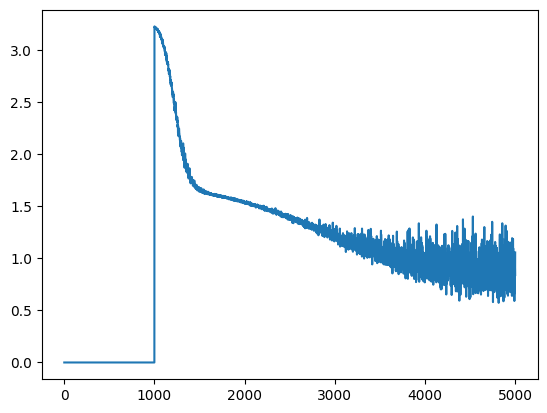

In [12]:
plt.plot(jnp.linalg.norm(grads_filtered, axis=(1, 2)))

In [13]:
to_save = {
    'model': trained_model,
    'losses': losses}
eqx.tree_serialise_leaves(f'koopmanAE_adaptive_lambda.eqx', to_save)